# Lab Work 10 : NLP Basics

This notebook builds on the tenth lecture of Foundations of Machine Learning. We'll focus on some *traditionnal* NLP technics, meaning not using any *transformer* architectures.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.

We will try to accurately predict if a tweet has been written by Donald Trump (until its account was banned) or by an AI. To build this dataset, we used a dataset that has collected several Donald Trump's tweet and we manually ask several models to wrote copies. More details on how the dataset was made in a separate notebook.
Let's load the dataset.

In [12]:
import pandas as pd

df = pd.read_csv("Donald_or_AI.csv")
df.head()

,content,generated,model
0,@ TiffanyATrump Happy birthday to my baby - an...,0,NaN
1,Receiving thousands of thank you letters from ...,0,NaN
2,It's important to remain open to new ideas and...,0,NaN
3,"Icahn, Kravis, Zell, Buffett have all used the...",0,NaN
4,Great going to Bob Kraft & Bill Belichick of t...,0,NaN


Tweets can be a challenge for NLP techniques :
* Only short snippets of text : we kept only tweets below 150 characters
* Some Twitter/X specificity : the "@" character and the "#" can carry meanings
* There can be some emojis in it

We will focus first on some cleaning before diving in the modelling.

## Data cleaning

In order to know what to perform, we suggest looking at some tweets or fake tweets first.

In [13]:
from random import sample

df["writer"] = df["model"].apply(lambda string: "Original" if pd.isna(string) else string)

indexes = sample(range(df.shape[0]), k=10)
for index in indexes:
    tweet = df["content"][index]
    writer = df["writer"][index]
    print(f"[{writer}] {tweet}")
    print("-"*25)

[Original] “You have to have confidence in yourself and confidence to know that what you are doing is right.” – Think Big
-------------------------
[Original] Forty -six million Americans---more than at any time ever in the history of this country--now live under the poverty line. # TimeToGetTough
-------------------------
[gemma3:4b] Sad! A truly great American family. We’re going to make this right. HUGE! #MAGA
-------------------------
[Original] @ EricTrump is doing a great job on completing our new Trump Winery in Virginia.
-------------------------
[Original] We left Iraq and it is quickly falling apart--what a waste of lives and money--and so obvious.
-------------------------
[Original] Back by popular demand, @ TraceAdkins delivers in the upcoming @ CelebApprentice All-Stars season. Yes, he sings.
-------------------------
[qwen2.5:3b] Fact: Without rural America's support, Trump's economy record would have been much worse! #KeepAmericaGreat
-------------------------
[gemma3:4

Given several rolls, we can see some points to clean :
* Some tweets ends with "\n" caracter
* Some tweets are all within double quotes
* Some tweets starts with ". " then a quote, it is unnecessary to keep
* Some tweets have double spaces, it is unnecessary to keep

Beside this format, we also note that the deepseek-r1 model wrote very long tweet. Let's display one :

In [14]:
print(df.loc[df["model"] == "deepseek-r1:1.5b", ]["content"].values[1])

<think>
Alright, so I need to come up with a Twitter tweet that's in line with Donald Trump's style. The user gave an example, which was a playful and funny one about drinking and staying hydrated. Let me analyze the structure and tone.

First, Trump uses humor and sarcasm often, especially towards people he deems problematic. His tweets usually start strong, sometimes with exclamation points or questions. They're concise and engaging.

Looking at the example: "You must be drinking too much of that garbage." It's a clear statement of defiance, using humor to mock someone else's behavior. The tone is sharp and humorous, appropriate for Twitter.

Now, I need to create my own tweet following this style. I should have a catchy phrase, perhaps with an emoji, question something, and use Trump-like wording.

Let me brainstorm some relevant topics around Trump's tweets: his policies, public relations, social media interactions, or maybe something about his style as an actor or artist. Since th

The Deepseek-R1 model is a **reasoning model** meaning he *thinks* before answering. The only part we need here is the part outside of the thinking process.

**Task** : Given all the previous discussion, write a `clean_tweet` function. It will also lower all characters.

In [15]:
import re
def clean_tweet(string):
    if string[0] == string[-1] == "\"":
        string = string[1:-1]
    if string[:2] == ". ":
        string = string[2:]
    if "<think>" in string:
        string = string.split("</think>")[1]
        string = string.strip()
    
    string = re.sub(r'[^\w\s]','', string)
    string = string.strip().lower()
    string.replace('  ', ' ')
    return string

Now that we have *cleaner* tweets to work on, we need to build features from it.

## Exploration and feature engineering

**Task** : Create the following columns, with only the first one being build on the raw tweets. The rest of them shall be derived from a cleaned version.
* `uppercase_ratio` : the proportion of uppercase character in the whole text. We may use the `isupper` method for a string.
* `character_count` : the number of character in the text
* `word_count` : the number of words in the text
* `avg_word_length` : the average length of words in the tweet

In [16]:
import numpy as np

df["uppercase_ratio"] = df["content"].apply(lambda string: sum([character.isupper() for character in string]) / len(string))

df["content"] = df["content"].apply(lambda string: clean_tweet(string))

df["character_count"] = df["content"].apply(lambda string: len(string))
df["word_count"] = df["content"].apply(lambda string: len(string.split()))
df["avg_word_length"] = df["content"].apply(lambda string: np.mean(np.array([len(word) for word in string.split()])))
df = df.loc[~df["avg_word_length"].isna(),]


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


We would like to see if the previous indicators we build might already help identifying AI. 

**Task** : Using seaborn's [`histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html) function with the appropriate parameters, explore the columns. We shall use the *hue* parameter with either the target column `generated` or the `writer`.

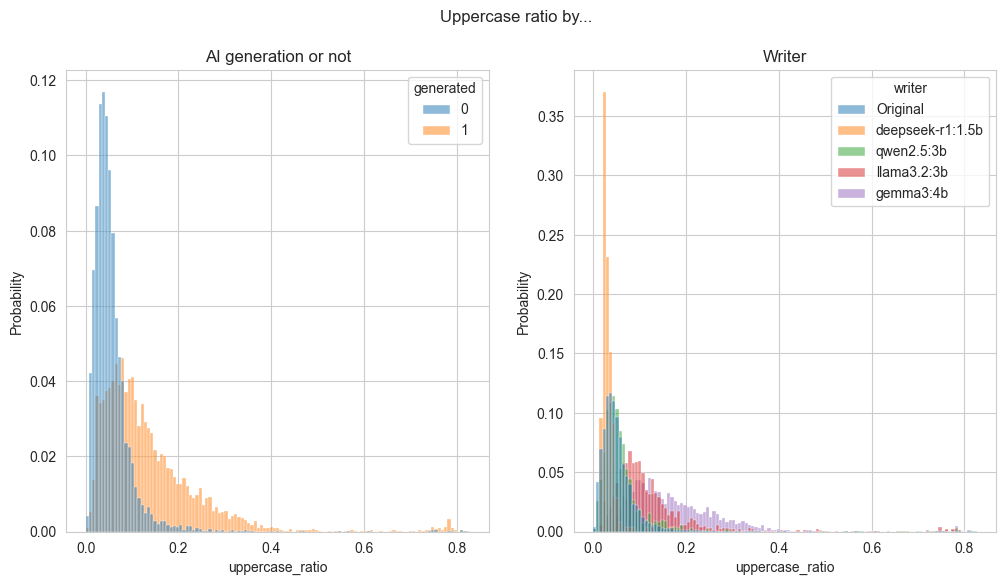

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style(style="whitegrid")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x="uppercase_ratio", hue="generated", stat="probability", common_norm=False)
plt.title("AI generation or not")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x="uppercase_ratio", hue="writer", stat="probability", common_norm=False)
plt.title("Writer")

plt.suptitle("Uppercase ratio by...")
plt.show()

## First modelisation

With not much work, can we already perform a classification ?

**Task** : Train a [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with a [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) in a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). We shall use the [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function to measure performance. Here, we'll use the [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) metric, so we will probably need the [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) function.
Bonus: use a [`TunedThresholdClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TunedThresholdClassifierCV.html).

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

features = ["uppercase_ratio", "character_count", "word_count", "avg_word_length"]
X = df[features]
y = df["generated"]

f1_scorer = make_scorer(f1_score)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", TunedThresholdClassifierCV(
        LogisticRegression(max_iter=500), scoring=f1_scorer)
    )
])

scores = cross_val_score(pipeline, X, y, scoring=f1_scorer, cv=5)
print(f"F1-Score: {scores.mean():.4f} (+/- {scores.std():.4f})")


F1-Score: 0.7292 (+/- 0.0733)


Already quite good performance without using the text.

## NLP modelisation

But it should be better with it.

**Task** : Still using a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class and the [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function, now use the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class with english stopwords and display results.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = df["content"].values
y = df["generated"]

pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words="english", max_features=500)),
    ("classifier", TunedThresholdClassifierCV(
        LogisticRegression(max_iter=500), scoring=f1_scorer)
    )
])

scores = cross_val_score(pipeline, X, y, scoring=f1_scorer, cv=5)
print(f"F1-Score: {scores.mean():.4f} (+/- {scores.std():.4f})")

F1-Score: 0.8959 (+/- 0.0469)


That is better ! But we could imagine stronger performance if we tuned a bit the vectorizer.

**Task** : Using the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class, find better parameter of both the vectorizer and the Logictic Regression.

In [20]:
from sklearn.model_selection import GridSearchCV


parameters = {
    "vectorizer__max_features": [100, 250, 500, 750, 1000],
    "vectorizer__ngram_range": [(1, 1), (1, 2), (2, 2)]
}

grid = GridSearchCV(pipeline, parameters)
grid.fit(X, y)
print(f"Best score: {grid.best_score_:.4f}")
print(f"Best parameters: {grid.best_params_}")


Best score: 0.9076
Best parameters: {'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}


But we only used words this time, not the previous statistics we had. 

## Third modelisation : combining approach

**Task** : Using the [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer), rewrite the pipeline so that it uses both numeric and text features.

As the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) expect 1D array, one need to use first [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer) to flatten the input using the `squeeze` method.

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

numeric_features = ["uppercase_ratio", "character_count", "word_count", "avg_word_length"]
text_feature = ["content"]

X = df[numeric_features + text_feature]
y = df["generated"]



numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

text_transformer = Pipeline(steps=[
    ("flatten", FunctionTransformer(lambda x: x.squeeze(), validate=False)),
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=1000, ngram_range=(1, 2)))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("text", text_transformer, text_feature)
    ]
)


pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", TunedThresholdClassifierCV(
        LogisticRegression(max_iter=500), scoring=f1_scorer)
    )
])

scores = cross_val_score(pipeline, X, y, scoring=f1_scorer, cv=5)
print(f"F1-Score: {scores.mean():.4f} (+/- {scores.std():.4f})")

F1-Score: 0.9036 (+/- 0.0414)


Now, it is up to you to make the performance better ! Here are some guidelines:
1. Make the dataset *cleaner* : there are probably still some work to do
2. Build better features : more useful statistics can be extracted
3. Find the most suitable model : note that we didn't fine-tune it, only the vectorizer...